# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.353468
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Noting that the softmax loss can be thought of as assigning a probability to each class, then because the weight matrix W is randomly initialized, we should expect that it would result in an image being classified as any of the 10 possible classes with equal probability 0.1. The full loss is then minus the log of the average over all images, which should also be approximately 0.1, plus the regularization, which is on the order of $(0.0001)^2 \ll - \log (0.1)$ as a result of the random initialization of the weights on the order of 0.0001.*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.783523 analytic: -3.783523, relative error: 2.151180e-09
numerical: -2.485062 analytic: -2.485062, relative error: 9.946774e-09
numerical: -4.928226 analytic: -4.928226, relative error: 2.419355e-09
numerical: 0.729395 analytic: 0.729395, relative error: 3.767954e-08
numerical: -1.275667 analytic: -1.275667, relative error: 3.307935e-08
numerical: -3.449171 analytic: -3.449171, relative error: 2.204763e-08
numerical: 1.801794 analytic: 1.801794, relative error: 1.951253e-08
numerical: 2.776163 analytic: 2.776163, relative error: 1.750058e-08
numerical: 2.622774 analytic: 2.622774, relative error: 1.454267e-08
numerical: 0.896589 analytic: 0.896589, relative error: 7.427041e-08
numerical: 0.569886 analytic: 0.569886, relative error: 8.111644e-08
numerical: -0.375095 analytic: -0.375095, relative error: 1.529064e-07
numerical: 2.061371 analytic: 2.061371, relative error: 2.841968e-08
numerical: -0.124883 analytic: -0.124883, relative error: 2.551571e-08
numerical: -3.025586

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.353468e+00 computed in 0.296276s
vectorized loss: 2.353468e+00 computed in 0.011307s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-8, 1e-7, 2.5e-7, 5e-7, 1e-6, 2.5e-6, 5e-6]
regularization_strengths = [5e3, 1e4, 2.5e4, 5e4, 1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for rate in learning_rates:
    for strength in regularization_strengths:
        softmax_val = Softmax()
        loss_hist = softmax_val.train(X_train, 
                                      y_train, 
                                      learning_rate=rate, 
                                      reg=strength, 
                                      num_iters=5000, 
                                      verbose=False)
        
        yt_pred = softmax_val.predict(X_train)
        yt_acc = np.mean(y_train == yt_pred)
        yv_pred = softmax_val.predict(X_val)
        yv_acc = np.mean(y_val == yv_pred)
        
        print('rate = %e, strength = %e, train acc = %f, val acc = %f' % (rate, strength, yt_acc, yv_acc))
        
        results[(rate, strength)] = (yt_acc, yv_acc)
        
        if yv_acc > best_val:
            best_val = yv_acc
            best_softmax = softmax_val

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# # Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

rate = 5.000000e-08, strength = 5.000000e+03, train acc = 0.369367, val acc = 0.375000
rate = 5.000000e-08, strength = 1.000000e+04, train acc = 0.357388, val acc = 0.374000
rate = 5.000000e-08, strength = 2.500000e+04, train acc = 0.329531, val acc = 0.343000
rate = 5.000000e-08, strength = 5.000000e+04, train acc = 0.305612, val acc = 0.323000
rate = 5.000000e-08, strength = 1.000000e+05, train acc = 0.284918, val acc = 0.295000
rate = 1.000000e-07, strength = 5.000000e+03, train acc = 0.373143, val acc = 0.395000
rate = 1.000000e-07, strength = 1.000000e+04, train acc = 0.356653, val acc = 0.374000
rate = 1.000000e-07, strength = 2.500000e+04, train acc = 0.332286, val acc = 0.345000
rate = 1.000000e-07, strength = 5.000000e+04, train acc = 0.303061, val acc = 0.314000
rate = 1.000000e-07, strength = 1.000000e+05, train acc = 0.282633, val acc = 0.290000
rate = 2.500000e-07, strength = 5.000000e+03, train acc = 0.374755, val acc = 0.390000
rate = 2.500000e-07, strength = 1.000000e+0

In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.378000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: *False*

*Your explanation*: For SVm loss, a new image could be added to the training set whose score with respect to its correct class is never greater than its scores with respect to all other incorrect classes by the margin specified in the loss function, therefore the SVM loss will be unchanged. However, Softmax loss does not "filter" scores in this way, therefore any new image in the training set will contribute to the total loss.

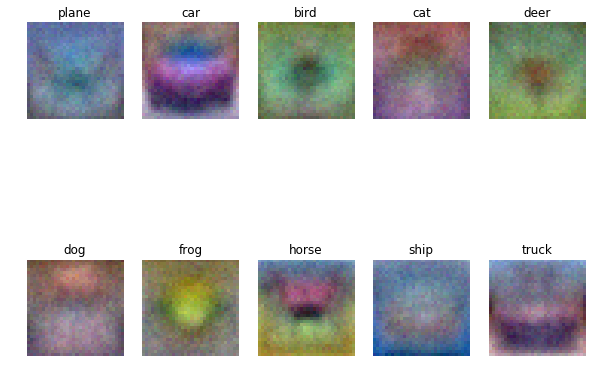

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])